<a href="https://colab.research.google.com/github/JohnSunny511/LangChain/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langchain langchain_core langchain_community langgraph langchain_google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
from google.colab import userdata
import os
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash",
    temperature=0.7)

In [ ]:
response=llm.invoke("Who is the prime minister of India")
response

KeyboardInterrupt: 

In [ ]:
from typing_extensions import TypedDict
class State(TypedDict):
  application: str
  experience: str
  skill_match : str
  response : str

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [ ]:
def categorize_experience(state: State) -> State:
    print("\n Categorizing the experince level of candidate:")
    prompt = ChatPromptTemplate.from_template(
    "Based on the job application categorize the positions as 'entry' , 'Mid-level' , 'senior-level'"
     "Application:{application}"
)

    chain = prompt | llm
    experience = chain.invoke({"application": state["application"]}).content
    print(f"Experience Level : {experience}")
    return {"experience" : experience}

def assess_skillset(state: State) -> State:
  print("\n Assesing Skill set of Candidate: ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the given application for a python developer, assses the candidates skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"skill_match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state:State) -> State:
  print("\nScheduling the interview: ")
  return {"response" : "Candidate has been shortlisted for HR interview."}


def escalate_to_recuriter(state: State) -> State:
  print("\nEscalating to Recuriter")
  return {"response" : "Candidate has experince but doesnt meet skill requirment."}


def reject_application(state: State) -> State:
  print("\nSending rejection email")
  return {"response" : "Candidate doesnt meeet JD and has been rejected"}

In [ ]:
workflow.add_node("categorize_experience", categorize_experience)

In [ ]:
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recuriter", escalate_to_recuriter)
workflow.add_node("reject_application", reject_application)

In [ ]:
def route_app(state: State) -> str:
    # LLMs can sometimes return extra whitespace or casing, so we strip/lower
    skill = state.get("skill_match", "").strip()
    exp = state.get("experience", "").lower()

    if "Match" in skill:
        return "schedule_hr_interview"
    elif "senior-level" in exp:
        return "escalate_to_recuriter"
    else:
        return "reject_application"

In [ ]:
workflow.add_edge("categorize_experience","assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

In [ ]:
workflow.add_edge(START,"categorize_experience")
workflow.add_edge("categorize_experience","assess_skillset")
workflow.add_conditional_edges(
    "assess_skillset",
    route_app,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recuriter": "escalate_to_recuriter",
        "reject_application": "reject_application"
    }
)
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recuriter", END)
workflow.add_edge("reject_application", END)

In [ ]:
app = workflow.compile()

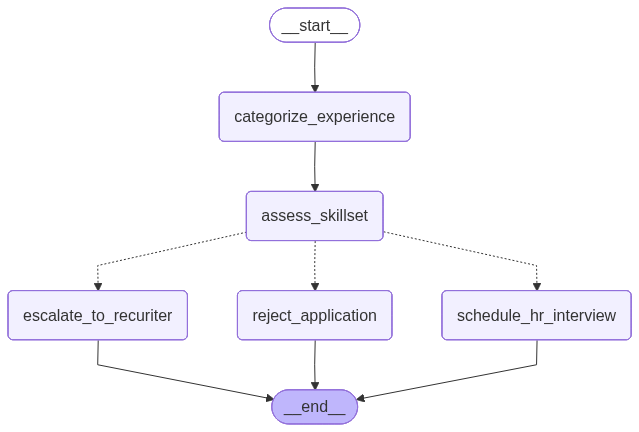

In [ ]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)